In [27]:
import pandas as pd
import numpy as np
import typing as t

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
import xgboost as xgb

In [29]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
df = pd.read_csv(data)

In [31]:
df.to_csv('car_fuel_efficiency.csv', index=False)

In [33]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [35]:
variable = 'fuel_efficiency_mpg'
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numeric_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)

In [37]:
def prep_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    for c in categorical_columns:
        df[c] = df[c].str.lower().str.replace(' ', '_')
        # Fill missing values
    df[categorical_columns] = df[categorical_columns].fillna('NA')
    df[numeric_columns] = df[numeric_columns].fillna(0.0)
    return df
    

In [39]:
def split_data(df: pd.DataFrame) -> t.Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train[variable].values
    y_val = df_val[variable].values
    y_test = df_test[variable].values

    del df_train[variable]
    del df_val[variable]
    del df_test[variable]

    df_full_train = df_full_train.reset_index(drop=True)

    return (df_train, y_train), (df_val, y_val), (df_test, y_test), df_full_train

(df_train, y_train), (df_val, y_val), (df_test, y_test), df_full_train = split_data(df)

## Question 1

In [41]:


dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

feature_names = dv.get_feature_names_out()
tree_rules = export_text(dt, feature_names=feature_names)
print(tree_rules)

root_feature_idx = dt.tree_.feature[0]
root_feature_name = feature_names[root_feature_idx]
print("Root split feature:", root_feature_name)


|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]

Root split feature: vehicle_weight


## Question 2

In [43]:


# root mean squared error function
def rmse(y_train, y_pred):
    se = (y_train - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(rmse(y_val, y_pred))

0.5053101538731283


## Question 3

      n   rmse
0    10  0.505
1    20  0.499
2    30  0.498
3    40  0.495
4    50  0.495
5    60  0.495
6    70  0.495
7    80  0.495
8    90  0.494
9   100  0.493
10  110  0.493
11  120  0.493
12  130  0.493
13  140  0.493
14  150  0.493
15  160  0.492
16  170  0.492
17  180  0.492
18  190  0.492
19  200  0.492


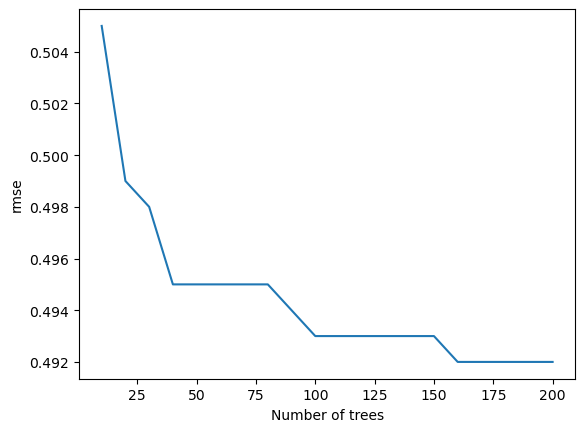

In [45]:


result = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    result.append((n, rmse(y_val, y_pred).round(3)))

df = pd.DataFrame(result, columns=['n', 'rmse'])
print(df)

plt.plot(df.n, df.rmse)
plt.xlabel('Number of trees')
plt.ylabel('rmse')
plt.show()


## Question 4

In [46]:


result = []
max_depths = [10, 15, 20, 25]
for d in max_depths:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        result.append((d, n, rmse(y_val, y_pred)))

df = pd.DataFrame(result, columns=['d', 'n', 'rmse'])
print(df)

# compute the mean per depth
df_mean = df.groupby('d')['rmse'].mean().sort_values()
print(df_mean.round(3))

     d    n      rmse
0   10   10  0.496067
1   10   20  0.492204
2   10   30  0.491705
3   10   40  0.488974
4   10   50  0.489313
..  ..  ...       ...
75  25  160  0.492518
76  25  170  0.492250
77  25  180  0.491988
78  25  190  0.491934
79  25  200  0.492105

[80 rows x 3 columns]
d
10    0.489
25    0.495
15    0.495
20    0.495
Name: rmse, dtype: float64


In [ ]:
## Question 6

[0]	train-rmse:1.81284	val-rmse:1.85421
[5]	train-rmse:0.50178	val-rmse:0.54658
[10]	train-rmse:0.36431	val-rmse:0.43548
[15]	train-rmse:0.34314	val-rmse:0.43002
[20]	train-rmse:0.33213	val-rmse:0.43000
[25]	train-rmse:0.32496	val-rmse:0.43149
[30]	train-rmse:0.31312	val-rmse:0.43431
[35]	train-rmse:0.30551	val-rmse:0.43488
[40]	train-rmse:0.29458	val-rmse:0.43555
[45]	train-rmse:0.28337	val-rmse:0.43730
[50]	train-rmse:0.27552	val-rmse:0.43879
[55]	train-rmse:0.27032	val-rmse:0.43949
[60]	train-rmse:0.26321	val-rmse:0.44126
[65]	train-rmse:0.25329	val-rmse:0.44218
[70]	train-rmse:0.24635	val-rmse:0.44334
[75]	train-rmse:0.23962	val-rmse:0.44400
[80]	train-rmse:0.23449	val-rmse:0.44529
[85]	train-rmse:0.22902	val-rmse:0.44661
[90]	train-rmse:0.22226	val-rmse:0.44750
[95]	train-rmse:0.21771	val-rmse:0.44812
[99]	train-rmse:0.21158	val-rmse:0.44869
[0]	train-rmse:2.28913	val-rmse:2.34556
[5]	train-rmse:1.41003	val-rmse:1.44557
[10]	train-rmse:0.90421	val-rmse:0.93576
[15]	train-rmse:0.62

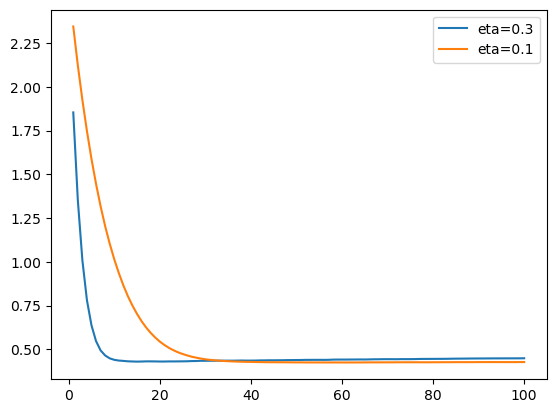

In [47]:


train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

features = dv.get_feature_names_out().tolist()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

# eta tunning
scores = {}
eta_params = [0.3, 0.1]
results  = []

for eta in eta_params:
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }
    evals_result = {}
    model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100, evals_result=evals_result, verbose_eval=5)

    val_rmses = evals_result['val']['rmse']
    best_rmse = min(val_rmses)
    best_round = val_rmses.index(best_rmse) + 1

    results.append((eta, best_rmse, best_round))

    key = f"eta={eta}"
    df_results = pd.DataFrame({
        'num_iter': range(1, len(evals_result['train']['rmse']) + 1),
        'train_rmse': evals_result['train']['rmse'],
        'val_rmse': evals_result['val']['rmse']
    })
    scores[key] = df_results

results_sorted = sorted(results, key=lambda x: x[1])

for eta, rmse_val, round_ in results_sorted:
    print(f"eta={eta}: best val RMSE={rmse_val:.4f} at round {round_}")

for key, df_scores in scores.items():
    plt.plot(df_scores['num_iter'], df_scores['val_rmse'], label=key)

plt.legend()
plt.show()